# Longitudinal analysis
Single site example of longitudinal data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from dataframe_help import add_temperature_w0_sw, calc_contrast

In [2]:
sites = ['P0029']

# Load data
df_par = pd.read_csv('../data/session_params.csv').drop(columns=['Unnamed: 0'])
df = pd.read_csv('../data/PSNR_df.csv').drop(columns=['index'])

df = add_temperature_w0_sw(df, '../data/')
df = df.drop(df[df['PSNR'] == np.inf].index).reset_index()
df['mod_PSNR'] = 10**(df['PSNR']/10)

df['Date'] = pd.to_datetime(df['Session'].str[:8], format='%Y%m%d')

df = df[df.Subject.isin(sites)]

df['RelPSNR'] = 100*(df.PSNR - df.PSNR.mean())/df.PSNR.mean()

Adding in temperature, w0 and SW: 100%|██████████| 242/242 [00:00<00:00, 1522.75it/s]


In [4]:
contrast_references = {'Adult':
                        {
                            'WM': {'Seg':'T2', 'LabelValue':9},
                            'GM': {'Seg':'T2', 'LabelValue':8}
                        },
                        'Neo':
                        {
                            'WM':{'Seg':'T2', 'LabelValue':4},
                            'GM': {'Seg':'T2', 'LabelValue':8}
                        }
                    }

df_con = pd.read_csv('../data/contrast_df.csv')

df_con = calc_contrast(df_con, contrast_references)
df_con = add_temperature_w0_sw(df_con, '../data')
df_con['Date'] = pd.to_datetime(df_con['Session'].str[:8], format='%Y%m%d')

df_con = df_con[df_con.Subject.isin(sites)]

df_con['RelNeo'] = 100*(df_con['Neonatal WM/GM Contrast'] - df_con['Neonatal WM/GM Contrast'].mean())/df_con['Neonatal WM/GM Contrast'].mean()


Adding in temperature, w0 and SW: 100%|██████████| 242/242 [00:00<00:00, 1913.59it/s]


In [5]:
df_scale_master = pd.read_csv('../data/distortions_scale_df.csv')
df_scale_master['Date'] = pd.to_datetime(df_scale_master['Session'].str[:8], format='%Y%m%d')
df_scale_axi = df_scale_master[(df_scale_master.Subject.isin(sites)) & (df_scale_master.Axis == 'axi')].copy()
df_scale_axi['Plate'] = df_scale_axi['Plate'].astype(str)
df_scale_axi['ScaleRel'] = None
df_scale_axi['rxyRel'] = None

for plate in ['0', '1', '2']:
    dd = df_scale_axi[df_scale_axi.Plate==plate]
    df_scale_axi.loc[df_scale_axi.Plate==plate, 'ScaleRel'] = 100*(dd.S - dd.S.mean())/dd.S.mean()
    df_scale_axi.loc[df_scale_axi.Plate==plate, 'rxyRel'] = 100*(dd.rxy - dd.rxy.mean())/(dd.rxy.mean()+1)

df_scale_cor = df_scale_master[(df_scale_master.Subject.isin(sites)) & (df_scale_master.Axis == 'cor')].copy()
df_scale_cor['ScaleRel'] = 100*(df_scale_cor.S - df_scale_cor.S.mean())/df_scale_cor.S.mean()
df_scale_cor['rxyRel'] = 100*(df_scale_cor.rxy - df_scale_cor.rxy.mean())/(df_scale_cor.rxy.mean()+1)
df_scale_cor['Axis'] = 'Coronal'

df_scale_sag = df_scale_master[(df_scale_master.Subject.isin(sites)) & (df_scale_master.Axis == 'sag')].copy()
df_scale_sag['ScaleRel'] = 100*(df_scale_sag.S - df_scale_sag.S.mean())/df_scale_sag.S.mean()
df_scale_sag['rxyRel'] = 100*(df_scale_sag.rxy - df_scale_sag.rxy.mean())/(df_scale_sag.rxy.mean()+1)
df_scale_sag['Axis'] = 'Sagittal'

df_scale_sagcor = pd.concat([df_scale_sag, df_scale_cor])

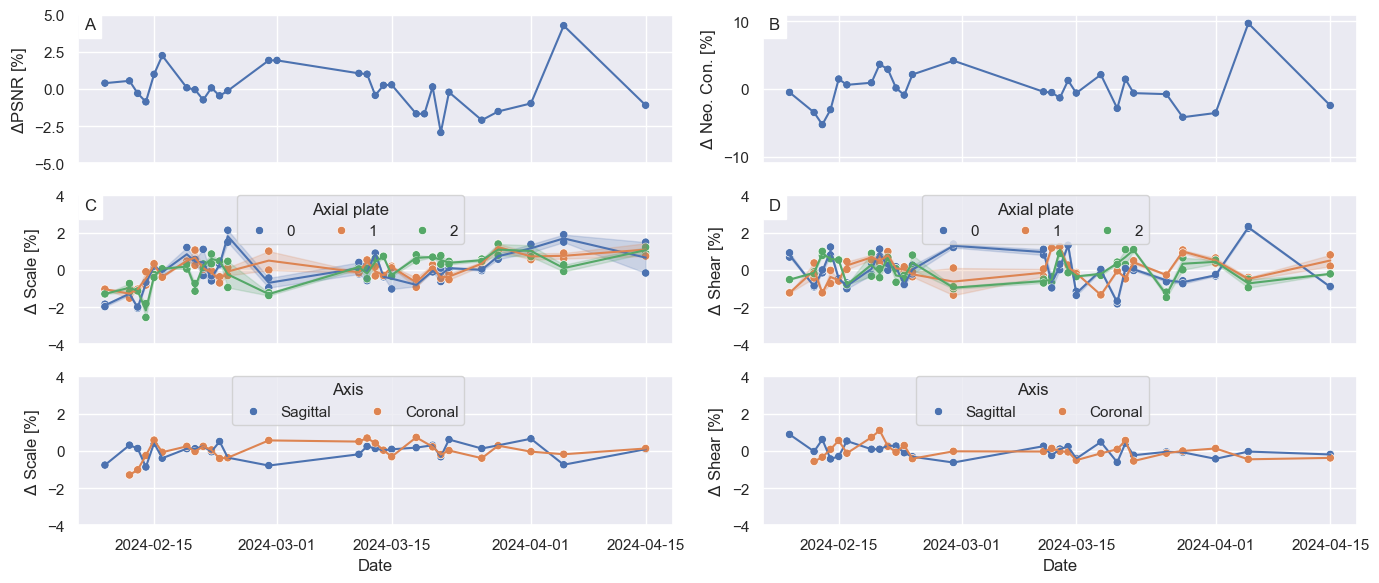

In [15]:
def add_letter(ax, fx, fy, my_string):
    y0,y1 = ax.get_ylim()
    y = y1 - (y1-y0)*fy
    ax.text(ax.get_xlim()[0]*(1+fx), y, my_string, backgroundcolor='w')

sns.set_theme()
fig, axes = plt.subplots(3,2, figsize=(14,6))

# PSNR
ax = axes[0,0]
sns.scatterplot(data=df, x='Date', y='RelPSNR', hue='Subject', ax=ax, legend=None)
sns.lineplot(data=df, x='Date', y='RelPSNR', hue='Subject', ax=ax, legend=None)
ax.set_ylabel(r'$\Delta$PSNR [%]')

# Neo contrast
ax = axes[0,1]
sns.scatterplot(data=df_con[df_con['Subject'].isin(sites)], x='Date', y='RelNeo', hue='Subject', ax=ax, legend=None)
sns.lineplot(data=df_con[df_con['Subject'].isin(sites)], x='Date', y='RelNeo', hue='Subject', ax=ax, legend=None)
ax.set_ylabel(r'$\Delta$ Neo. Con. [%]')

# Scale
ax = axes[1,0]
sns.scatterplot(data=df_scale_axi, x='Date', y='ScaleRel', hue='Plate', ax=ax)
sns.lineplot(data=df_scale_axi, x='Date', y='ScaleRel', hue='Plate', ax=ax, legend=None)
ax.set_ylabel(r'$\Delta$ Scale [%]')

ax = axes[2,0]
sns.scatterplot(data=df_scale_sagcor, x='Date', y='ScaleRel', hue='Axis', ax=ax)
sns.lineplot(data=df_scale_sagcor, x='Date', y='ScaleRel', hue='Axis', ax=ax, legend=None)
ax.set_ylabel(r'$\Delta$ Scale [%]')

# Shear
ax = axes[1,1]
sns.scatterplot(data=df_scale_axi, x='Date', y='rxyRel', hue='Plate', ax=ax)
sns.lineplot(data=df_scale_axi, x='Date', y='rxyRel', hue='Plate', ax=ax, legend=None)
ax.set_ylabel(r'$\Delta$ Shear [%]')

ax = axes[2,1]
sns.scatterplot(data=df_scale_sagcor, x='Date', y='rxyRel', hue='Axis', ax=ax)
sns.lineplot(data=df_scale_sagcor, x='Date', y='rxyRel', hue='Axis', ax=ax, legend=None)
ax.set_ylabel(r'$\Delta$ Shear [%]')


axes[0,0].set_xlabel(None); axes[0,0].set_xticklabels([])
axes[0,1].set_xlabel(None); axes[0,1].set_xticklabels([])
axes[1,0].set_xlabel(None); axes[1,0].set_xticklabels([])
axes[1,1].set_xlabel(None); axes[1,1].set_xticklabels([])

axes[0,0].axis([None,None, -5, 5])
axes[0,1].axis([None,None, -11, 11])
axes[1,0].axis([None,None, -4, 4])
axes[1,1].axis([None,None, -4, 4])
axes[2,0].axis([None,None, -4, 4])
axes[2,1].axis([None,None, -4, 4])

add_letter(axes[0,0], 0.4E-4, 1E-1, 'A')
add_letter(axes[0,1], 0.4E-4, 1E-1, 'B')
add_letter(axes[1,0], 0.4E-4, 1E-1, 'C')
add_letter(axes[1,1], 0.4E-4, 1E-1, 'D')

axes[1,0].legend(bbox_to_anchor=(.65, 1), loc='upper right', borderaxespad=0., ncol=3, title='Axial plate')
axes[1,1].legend(bbox_to_anchor=(.65, 1), loc='upper right', borderaxespad=0., ncol=3, title='Axial plate')
axes[2,1].legend(bbox_to_anchor=(.65, 1), loc='upper right', borderaxespad=0., ncol=2, title='Axis')
axes[2,0].legend(bbox_to_anchor=(.65, 1), loc='upper right', borderaxespad=0., ncol=2, title='Axis')

plt.tight_layout()
plt.savefig('../results/figure11_longitudinal.png', dpi=300)
plt.show()

In [7]:
print(f"Data between: {df_scale_axi.Date.min()} and {df_scale_axi.Date.max()}")
print(f"Number of sessions: {len(df_scale_axi.Session.unique())}")

Data between: 2024-02-09 00:00:00 and 2024-04-15 00:00:00
Number of sessions: 27
